In [1]:
import sys
print(sys.version)

3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]


In [ ]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import imdb
from sklearn.model_selection import train_test_split
from keras.models import Sequential

In [ ]:
tf.keras.utils.set_random_seed(42)

In [ ]:
# num_words = 자주 사용되는 문장 선택
(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)

In [ ]:
train_input, val_input, train_target, val_target = train_test_split(train_input,
                                                                    train_target,
                                                                    test_size=0.3,
                                                                    random_state=42)
lengths = np.array([len(x) for x in train_input])
len(lengths)

17500

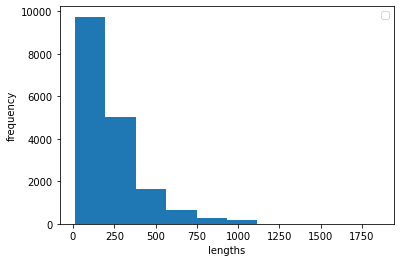

In [ ]:
plt.hist(lengths)
plt.xlabel('lengths')
plt.ylabel('frequency')
plt.legend()
plt.show()

In [ ]:
from keras.utils import pad_sequences, to_categorical

In [ ]:
# 열을 특정 값으로 맞춤 / 부족할 경우 0으로 채움
train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

print((train_seq[0]))
print((train_input[0]))

[ 40   4   2   7   4 274  33   4   2 388  11   4  65  21   2  41   2   8
 216  46  11   2   2 139   4   2  15   2   5   2   2  11  68 139 295   9
  82   2   5 283   8   2   5   2   2   2  17  73   4   2 156  82   2  68
   2   2   5   4   2   2   4   2   2   7   4  65  10  10  13   2 386  14
 310   7   4 356   2   2  48  25  28  24 332   4 274 159  95  25  70 106
  14 365  17   6   2   2   8  14 307  65]
[1, 13, 2, 2, 2, 2, 11, 312, 396, 5, 12, 317, 72, 19, 6, 2, 2, 133, 16, 6, 307, 2, 44, 6, 185, 2, 2, 8, 169, 119, 5, 2, 11, 4, 465, 211, 7, 2, 2, 14, 185, 255, 16, 2, 2, 6, 338, 5, 2, 109, 19, 6, 2, 330, 5, 80, 7, 41, 205, 41, 65, 63, 2, 2, 143, 2, 205, 2, 16, 199, 2, 5, 2, 10, 10, 17, 173, 7, 263, 2, 75, 296, 4, 2, 2, 7, 4, 65, 5, 12, 2, 72, 245, 4, 2, 201, 24, 64, 93, 4, 2, 8, 2, 283, 8, 2, 204, 2, 5, 4, 2, 7, 4, 65, 21, 4, 156, 37, 2, 4, 105, 71, 43, 87, 199, 2, 2, 2, 2, 5, 2, 2, 2, 2, 34, 4, 403, 7, 2, 2, 2, 4, 2, 7, 68, 105, 13, 2, 2, 259, 334, 11, 68, 2, 4, 85, 354, 7, 2, 11, 85, 

In [ ]:
from keras.layers import Dense, SimpleRNN,LSTM,Dropout,CuDNNLSTM

In [ ]:
model = Sequential()
# LSTM - GRU - 트렌스포머
model.add(CuDNNLSTM(32, input_shape=(100,500)))
# relu, sigmoid, adam
model.add(Dense(1, activation='relu'))
 hbn 
# one hot encoding
train_oh = to_categorical(train_seq)
val_oh = to_categorical(val_seq)
val_oh.shape
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm (CuDNNLSTM)      (None, 32)                68352     
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 68,385
Trainable params: 68,385
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Root Mean Square Propagation
# 최근 time step 에서의 기울기는 많이 반영
# 먼 과거의 time step 기울기는 조금 반영
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
# 이진분류
model.compile(optimizer=rmsprop,
              loss='binary_crossentropy',
              # accuracy / f1score
              metrics=['accuracy'])

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('best_simpleRNN.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
# callback함수: 특정 이벤트(시그널)에 의해서 호출

In [ ]:
fit_model = model.fit(train_oh, train_target,
                      batch_size=1000,
                      epochs=20,
                      validation_data=(val_oh, val_target),
                      callbacks=[checkpoint_cb,
                                 early_stopping_cb])

Epoch 1/20
18/18 [==============================] - 5s 192ms/step - loss: 3.9533 - accuracy: 0.5029 - val_loss: 2.0498 - val_accuracy: 0.4932
Epoch 2/20
18/18 [==============================] - 1s 78ms/step - loss: 1.7241 - accuracy: 0.5029 - val_loss: 1.5550 - val_accuracy: 0.4932
Epoch 3/20
18/18 [==============================] - 1s 79ms/step - loss: 1.4206 - accuracy: 0.5029 - val_loss: 1.3394 - val_accuracy: 0.4932
Epoch 4/20
18/18 [==============================] - 1s 78ms/step - loss: 1.2379 - accuracy: 0.5029 - val_loss: 1.1705 - val_accuracy: 0.4932
Epoch 5/20
18/18 [==============================] - 1s 78ms/step - loss: 1.0824 - accuracy: 0.5029 - val_loss: 1.0234 - val_accuracy: 0.4932
Epoch 6/20
18/18 [==============================] - 1s 78ms/step - loss: 0.9492 - accuracy: 0.5029 - val_loss: 0.8984 - val_accuracy: 0.4932
Epoch 7/20
18/18 [==============================] - 1s 79ms/step - loss: 0.8389 - accuracy: 0.5029 - val_loss: 0.7978 - val_accuracy: 0.4932
Epoch 8/20
1

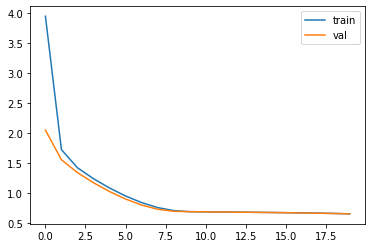

In [ ]:
plt.plot(fit_model.history['loss'])
plt.plot(fit_model.history['val_loss'])
plt.xlabel=('epochs')
plt.ylabel=('loss')
plt.legend(['train','val'])
